# Sensor Orientation (Two station approach)
This will download seismic waveforms & measure sensor orientation for a target station. ObsPy, numpy, scipy, matplotlib are required.

## Import ObsPy module

In [1]:
from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth

from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.rotate import rotate_rt_ne
from obspy.signal.rotate import rotate2zne

import obspy as ob
print("# obspy version = ",ob.__version__)

# obspy version =  1.2.2


## Import SciPy, NumPy, matplotlib module

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl

print("# numpy version = ",np.__version__)
print("# scipy version = ",sp.__version__)
print("# matplotlib version = ",mpl.__version__)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates 


from scipy import signal
from scipy import ndimage

from scipy.fftpack import fft, ifft
from scipy.linalg import norm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

import sys
import os


# numpy version =  1.19.1
# scipy version =  1.5.2
# matplotlib version =  3.3.1


## Font size

In [3]:
# font size
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#SMALL_SIZE = 32
#MEDIUM_SIZE = 32
#BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## function: get_seedid
to extract seed_id from obspy stream.

In [4]:
def get_seedid (tr):
    seedid=tr.stats.network+"."+tr.stats.station+"."+tr.stats.location+"."+tr.stats.channel
    return seedid

## function: st_remove_resp
to correct instrument response.

In [5]:
def st_remove_resp (st, deciopt, decifactor, pre_filt, output):
    st.detrend() # remove linear trend
    st.detrend("demean") # demean
    st.taper(0.05) # cosin taper

    if deciopt == 1:
        # decimate to 100Hz
        if decifactor == 100:     
            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

            st.decimate(5, strict_length=False)
            st.decimate(2, strict_length=False)

        else:
            st.decimate(factor=decifactor, strict_length=False)
    
    st = st.remove_response(pre_filt=pre_filt,output=output,water_level=None) # get velocity data (m/s)

    return st


## function: get_sta_coord
to extract station coordinate from obspy stream.

In [6]:
def get_sta_coord (seedid, inv, starttime):
    sta_coordinate = inv.get_coordinates(seedid, starttime)
    return sta_coordinate


## function: get_sta_orientation
to extract sensor orientation from obspy stream.

In [7]:
def get_sta_orientation (seedid, inv, starttime):
    sta_orientation = inv.get_orientation(seedid, starttime)
    return sta_orientation


## function: get_zne_data
to rotate 3-com data into ZNE coordinate

In [8]:
def get_zne_data (st, inv, starttime):

    st_len = len(st)
    
    if st_len != 3:
        print("# cannot do!")
        

    sta_coordinate = []
    sta_orientation = []

    #for tr in st1:
    for i, tr in enumerate(st, 1):
        #print("# i = ",i)
        seedid=get_seedid(tr)
        #sta_coordinate[i] = get_sta_coord(tr, seedid, inv1, starttime)

        sta_coordinate.append(get_sta_coord(seedid, inv, starttime))
        sta_orientation.append(get_sta_orientation(seedid, inv, starttime))

        #print("# seedid = ",seedid, sta_coordinate)
        #print("# seedid = ",seedid, sta_orientation)

    ztmp = st[2]
    AzZ = sta_orientation[2]['azimuth']
    DipZ = sta_orientation[2]['dip']
    #print("# AzZ = ", AzZ, " DipZ = ", DipZ)
    
    ntmp = st[1]
    AzN = sta_orientation[1]['azimuth']
    DipN = sta_orientation[1]['dip']
    #print("# AzN = ", AzN, " DipN = ", DipN)

    etmp = st[0]
    AzE = sta_orientation[0]['azimuth']
    DipE = sta_orientation[0]['dip']
    #print("# AzE = ", AzE, " DipE = ", DipE)

    
    t1z , t1n, t1e = rotate2zne(ztmp,AzZ,DipZ,ntmp,AzN,DipN,etmp,AzE,DipE)
    st[0].data = t1e
    st[1].data = t1n
    st[2].data = t1z
    #i_1.stats.channel[:-1] + \
    #                output_components[0]
    st[0].stats.channel = st[0].stats.channel[:-1] + "E"
    st[1].stats.channel = st[0].stats.channel[:-1] + "N"
    st[2].stats.channel = st[0].stats.channel[:-1] + "Z"

    return st


## function: get_baz
to compuete back-azimuth

In [9]:
def get_baz (st, inv, evla, evlo):
    seedid=get_seedid(st[0])
    sta_coord = get_sta_coord(seedid,inv,starttime)
    
    stla = sta_coord['latitude']
    stlo = sta_coord['longitude']
    
    source_latitude = evla
    source_longitude = evlo
    
    station_latitude = stla
    station_longitude = stlo
    
    # theoretical backazimuth and distance
    baz = gps2dist_azimuth(source_latitude, source_longitude, station_latitude, station_longitude)

    #print('Epicentral distance [m]: ', baz[0])
    #print('Theoretical azimuth [deg]: ', baz[1])
    #print('Theoretical backazimuth [deg]: ', baz[2])
    
    return baz

## function: total_power_sqrt
compute sqrt(total power) for obspy stream data

In [10]:
def total_power_sqrt (st):

    st_total_power_sqrt = norm(st[0].data,2)
    
    return st_total_power_sqrt

## function: st_normalize
normalize obspy stream data

In [11]:
def st_normalize(st, val):
    st[0].data = st[0].data/val
    return st


## function: cal_max_emin
compute a confidence interval with F-distribution

In [12]:
def cal_max_emin (conf_level, num_para, deg_freedom):
#http://www.socr.ucla.edu/Applets.dir/F_Table.html
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/en_Tanagra_Calcul_P_Value.pdf
    
#para conf_level (%). e.g., 95%

    nf1 = num_para
    nf2 = deg_freedom - num_para
    coeff = nf1 / nf2 

    
    q=(conf_level*0.01)
    #print("# q = ", q)
    # alpha is 1-q -> 0.05
    quantile_of_dist = sp.stats.f.ppf(q=q, dfn=nf1, dfd=nf2)
    #print("# quantile_of_dist = ",quantile_of_dist )
    max_emin = 1+(coeff*quantile_of_dist)

    #print("# max_emin = ", max_emin)
    
    return max_emin
    

## Set client (Data Center) for event search
This example uses USGS. We can use other dataceneter (e.g., NCEDC, IRIS)

In [14]:
#clientEQ = Client("IRIS")
clientEQ = Client("USGS")

## Event search
Set time window (st, et) and a range of magunitude (minmag, maxmag). This example will find the 15 October 2020 M 2.6 Pleasant Hill event.

1 Event(s) in Catalog:
2019-10-15T06:55:05.880000Z | +37.937, -122.065 | 2.57 md | manual


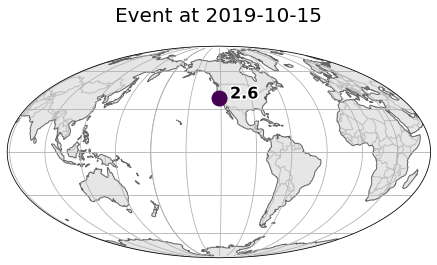

In [15]:
#M 2.6 - 1km SSW of Pleasant Hill, CA
#2019-10-15 06:55:05 (UTC)37.937°N 122.065°W12.5 km depth
st = UTCDateTime("2019-10-15T06:00:00")  # 
et = UTCDateTime("2019-10-15T08:00:00")  #
minmag = 2.5
maxmag = 3.0       
#[noise:/ref/bsl/taira/Operations/Instrumentation/BDSN_SRL/TScopeAz/data/1.0-5.0Hz.0.5-6.0Hz.06.14.20.noerror.bbNset0Eset90/BK.BRIB/Ref_BK.BRIB/73292045.BRIBref_1.0-5.0Hz 85] gs *ps

catalog = clientEQ.get_events(starttime=st , endtime=et,
                            minmagnitude=minmag, maxmagnitude=maxmag)
print(catalog)

_plot = catalog.plot()


## Extract event information


In [16]:
# event info. origin time, location, magnitude
event = catalog[0]
origin = event.origins[0]
origin_time = origin.time
evla = origin.latitude
evlo = origin.longitude
evdp_km = origin.depth / 1000
evmag = event.magnitudes[0].mag

evyearOUT = origin_time.year
evjdayOUT = origin_time.julday
evhourOUT = origin_time.hour
evminOUT = origin_time.minute
evsecOUT = origin_time.second

evid = event.origins[0]['extra']['dataid']['value']
event_region = event.event_descriptions[0]['text']

#print("# evid = ",evid)
#print("# event_region = ",event_region)

In [17]:
# need for file name
evyearOUT2 = (str)(evyearOUT)
evjdayOUT2 = (str)(evjdayOUT)
if evjdayOUT < 100:
    evjdayOUT2 = "0"+(str)(evjdayOUT)
        

if evjdayOUT < 10:
    evjdayOUT2 = "00"+(str)(evjdayOUT)
    

evhourOUT2 = (str)(evhourOUT)
if evhourOUT < 10:
    evhourOUT2 = "0"+(str)(evhourOUT)
        

evminOUT2 = (str)(evminOUT)
if evminOUT < 10:
    evminOUT2 = "0"+(str)(evminOUT)


evsecOUT2 = (str)(evsecOUT)
if evsecOUT < 10:
    evsecOUT2 = "0"+(str)(evsecOUT)
        
        
#print("# evyearOUT2 = ",evyearOUT2," evjdayOUT2 = ",evjdayOUT2," evhourOUT2 = ",evhourOUT2," evminOUT2 = ",evminOUT2," evsecOUT2 = ",evsecOUT2)
    
evmseedid = evyearOUT2+"."+evjdayOUT2+"."+evhourOUT2+""+evminOUT2+""+evsecOUT2
#print("# evmseedid = "+evmseedid)

event_para = evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)


## Directory for waveform plot
This example will create directory "2019.288.065505_M2.57_nc73292045" where all plots will be saved.

In [18]:
# name for output directory
pwd_dir = os.getcwd() 
#sacdir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(eventid_ncedc)+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distkm_from_eq)+"km"
#plot_dir= pwd_dir +"/"+ evmseedid +"_M"+(str)(evmag)+"_"+(str)(evid)
#+"_fl"+(str)(f2)+"_fh"+str(f3)+"_dist"+(str)(distdeg_from_eq)+"deg"


plot_dir= pwd_dir +"/"+ event_para

print("# plot_dir = ",plot_dir)

# create output directory
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


# plot_dir =  /Users/taira/work/python_work/2019.288.065505_M2.57_nc73292045


## Set time window for downloading seismic data
This example extracts 5-min data for the 2020 M 2.6 Pleasant Hill earthquake

In [19]:
pre_tw = -90 # 0s if this is -10, then data from -10s from the origin time
stw = 5*60 # 5 min from the starting time (oriting_time + pre_tw)

starttime = origin_time + pre_tw  
endtime = starttime + stw

#print("# starttime = ",starttime)

## Set SNCL parameters
Which SNCL (Station, Network, Component, Location) we will use? sta1,net1,com1,loc1 for the target data, sta2,net2,com2,loc2 for the reference data.

In [20]:
# targert
sta1 = "BRIB" # station
net1 = "BK" # network
com1 = "HN?" # component "HH?" to get all 3-com data from broadband sensor
loc1 = "01" # location

deciopt_1 = 0
#decifactor_1 = 100 # 100sps -> 1sps
decifactor_1 = 10 # 100sps -> 10 sps

client1 = Client("NCEDC") # data from NCEDC

In [21]:
# reference
sta2 = "BRIB" # station
net2 = "BK" # network
com2 = "HH?" # component "HN?" to get all 3-com data from strong-motion sensor
loc2 = "01" # location

deciopt_2 = 0
#decifactor_2 = 100
decifactor_2 = 10

client2 = Client("NCEDC") # data from IRIS

## Set time window for sensor orientation

In [22]:
p_vel = 4.2 # P-wave velocity (km/s) 
tw_pre_tw = -3 # sec before p wave arrival
tw_trim = 20 # 20-s window length


## Set frequency range for sensor orientation
set the frequency range (fl and fh) for sensor orientation measurements. This example will use 1.0-5.0 Hz band. Also this will use for pre-filter when we correct the instrument response.

In [23]:
#fl2 < fl < fh < fh2
fl2 = 0.5 # Hz
fl = 1.0 # Hz 
fh = 5.0 #  Hz
fh2 = 6.0 # Hz
#pre_filt = [0.015, 0.02, 45, 50]
pre_filt = [fl2, fl, fh, fh2]

## Downloading seismic data
use get_waveforms to download data and do st.plot() for plotting. Also use get_stsations to obtation station inventory file. 

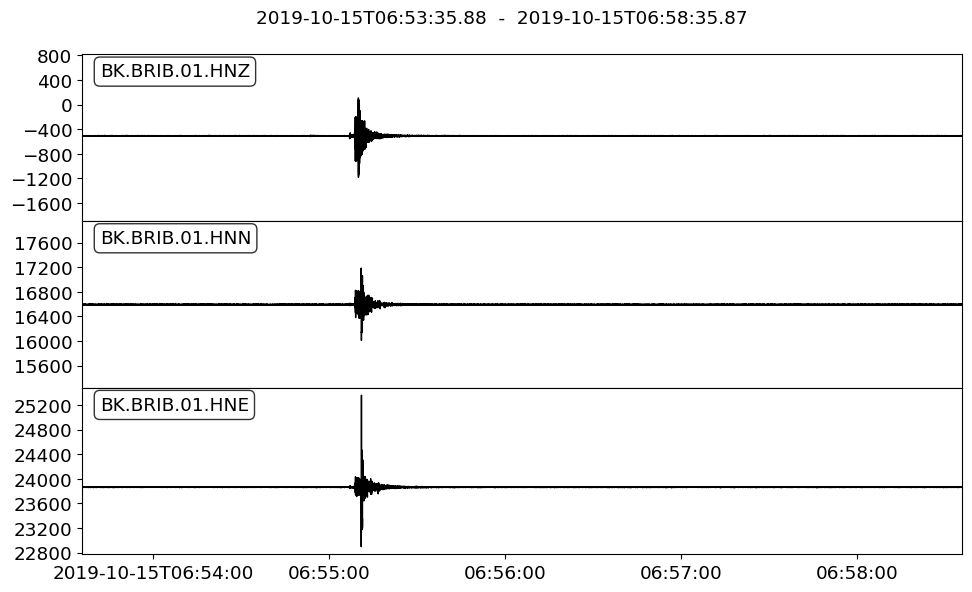

In [24]:
st1 = client1.get_waveforms(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)
inv1 = client1.get_stations(network=net1, station=sta1, location=loc1, channel=com1,
                     starttime=starttime, endtime=endtime, 
                     level="response")
_plot = st1.plot(size=(1000,600))
#_plot = st1.plot()


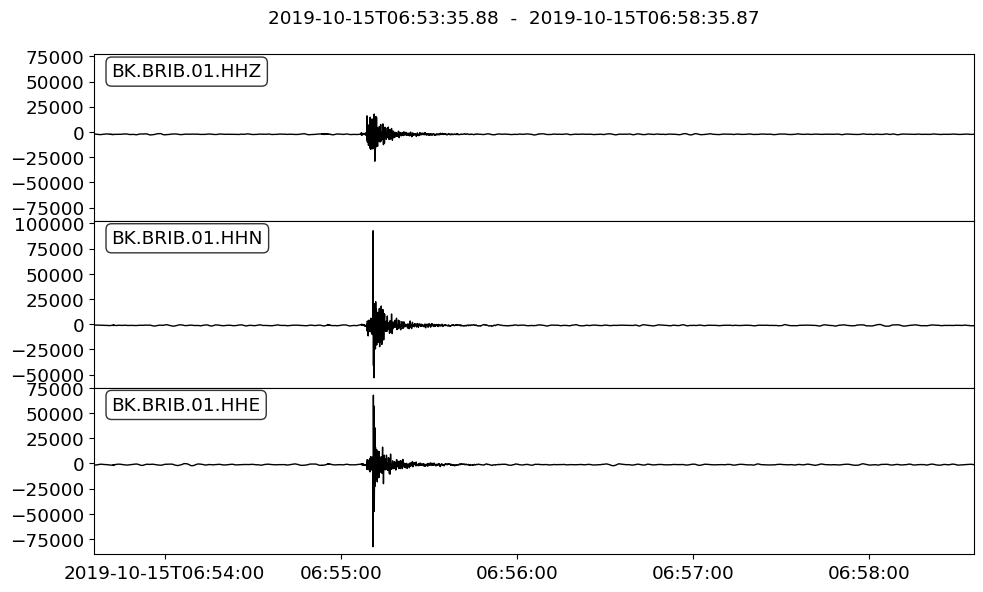

In [25]:
st2 = client2.get_waveforms(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     attach_response=True)


# for station locations
inv2 = client2.get_stations(network=net2, station=sta2, location=loc2, channel=com2,
                     starttime=starttime, endtime=endtime, 
                     level="response")

_plot = st2.plot(size=(1000,600))

## Removing instrument response 
use st_remove_resp function uses obspy remove_response to remove instrument response. Example will provide ground acceleration data (m/s**2)

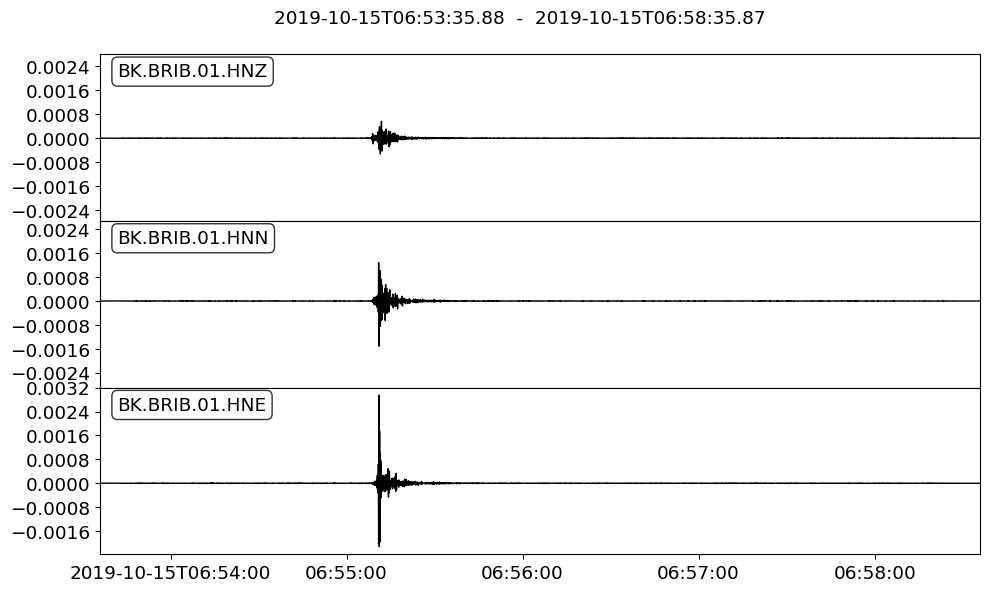

In [26]:
st1 = st_remove_resp(st1, deciopt_1, decifactor_1, pre_filt, "ACC")

_plot = st1.plot(size=(1000,600))

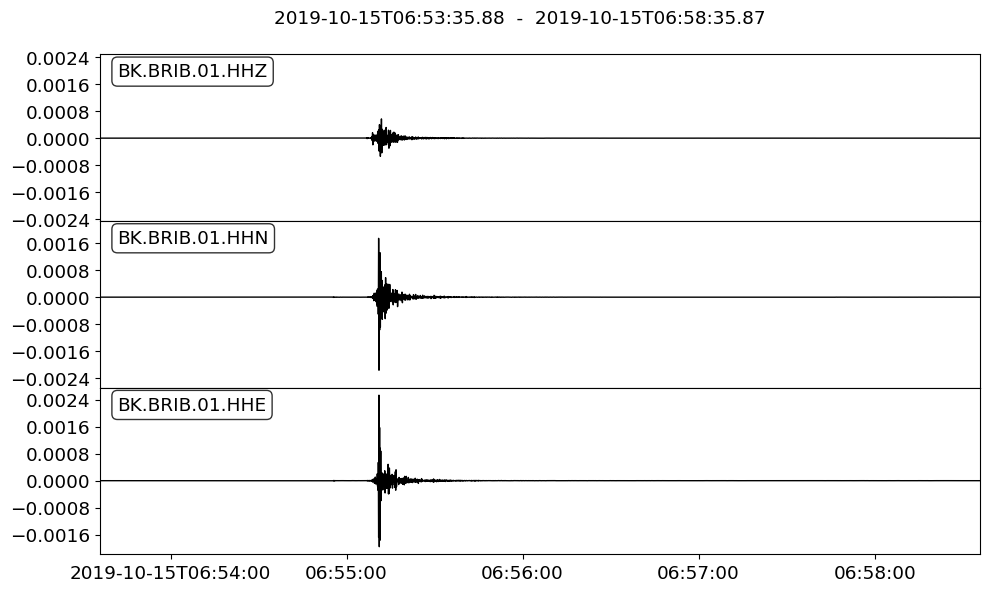

In [27]:
st2 = st_remove_resp(st2, deciopt_2, decifactor_2, pre_filt, "ACC")

_plot = st2.plot(size=(1000,600))

## Rotating seismic data into ZNE coordinate
use get_zne_data. This will provide ZNE coordinate data. 

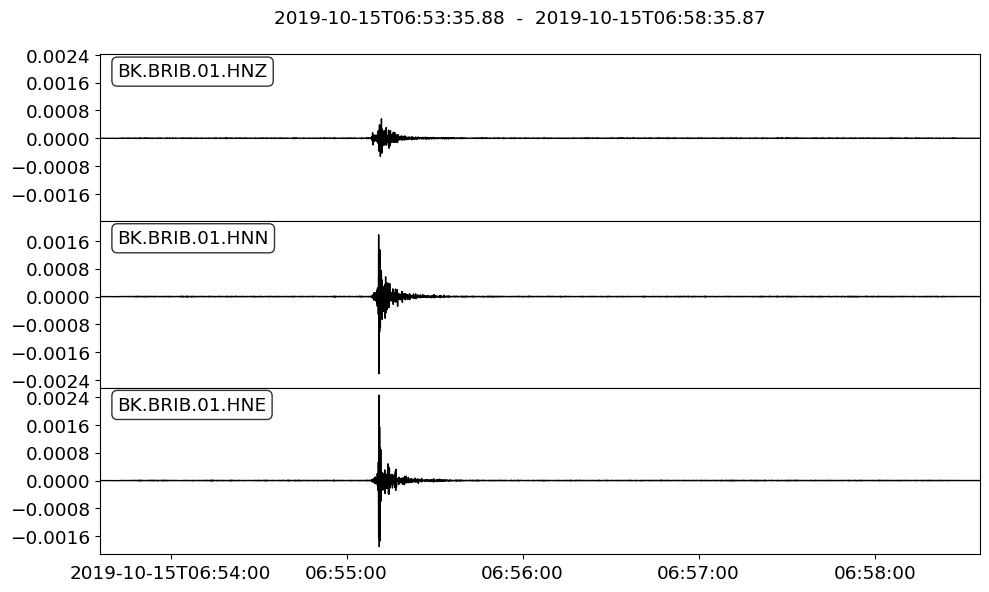

In [28]:
# st1 (target event data do not need this)
st1_zne = st1.copy()
st1_zne = get_zne_data (st1_zne, inv1, starttime)
_plot = st1_zne.plot(size=(1000,600))

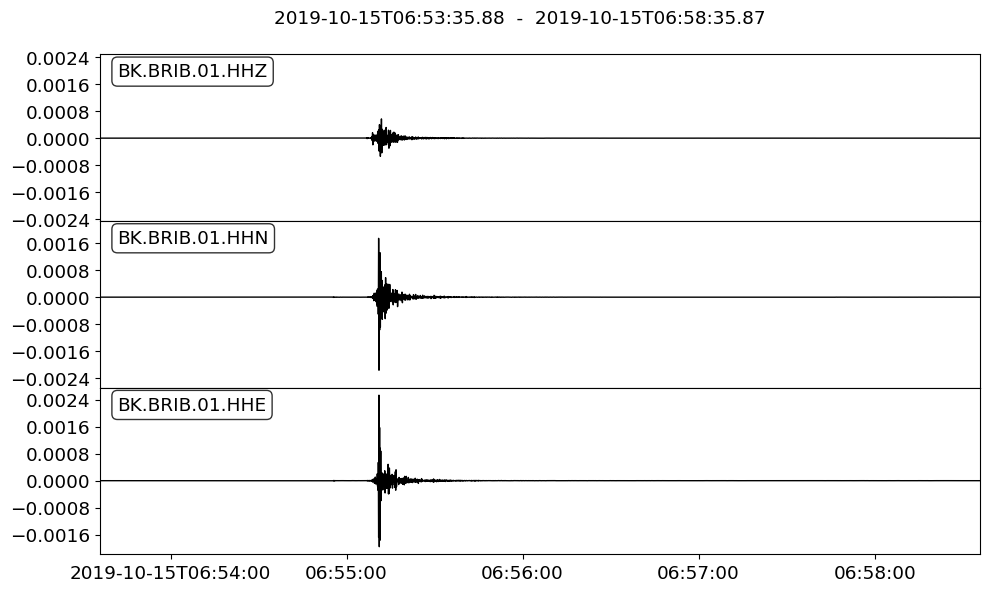

In [29]:
st2_zne = st2.copy()
st2_zne = get_zne_data (st2_zne, inv2, starttime)
_plot = st2_zne.plot(size=(1000,600))

## Rotating seismic data into ZRT coordinate 
get_baz to esimate the back azimuth and then use obspy rotate to covert ZNE data into ZRT data

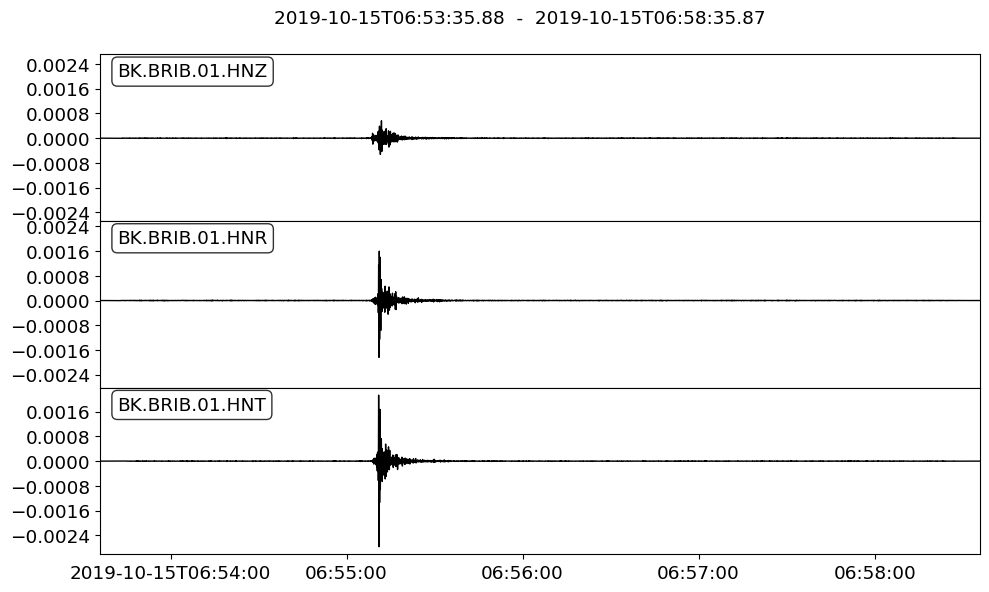

In [30]:
baz1 = get_baz(st1, inv1, evla, evlo)
st1_zrt = st1_zne.copy()
st1_zrt.rotate(method='NE->RT',back_azimuth=baz1[2])
_plot = st1_zrt.plot(size=(1000,600))

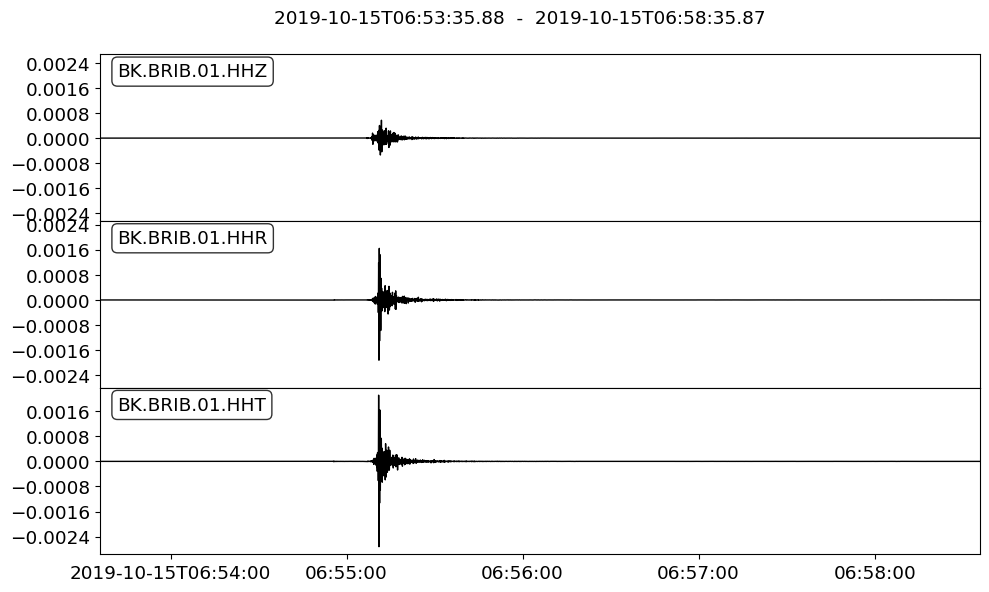

In [31]:
baz2 = get_baz(st2, inv2, evla, evlo)
st2_zrt = st2_zne.copy()
st2_zrt.rotate(method='NE->RT',back_azimuth=baz2[2])
_plot = st2_zrt.plot(size=(1000,600))

In [32]:
diff_eq_dist = (baz1[0] - baz2[0]) / 1000.0
diff_eq_baz = (baz1[2] - baz2[2])
#print("# diff_eq_dist = ",diff_eq_dist)
#print("# diff_eq_baz = ",diff_eq_baz)

## Combining all streams
st_all includ all ZNERT data from two stations

In [33]:
# we now combine st2zrt and original st1. 
st_all = st2_zrt.copy()  + st1.copy()
#st_all = st2.copy()  + st1.copy()
print(st_all)

6 Trace(s) in Stream:
BK.BRIB.01.HHT | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples
BK.BRIB.01.HHR | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples
BK.BRIB.01.HHZ | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples
BK.BRIB.01.HNE | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples
BK.BRIB.01.HNN | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples
BK.BRIB.01.HNZ | 2019-10-15T06:53:35.880000Z - 2019-10-15T06:58:35.870000Z | 100.0 Hz, 30000 samples


## Computing arrival time of P-wave wave
event ditance / p_vel (This example uses 4.2 km/s)

In [34]:
Pwave_arrival = baz2[0]/1000.0/p_vel

## Trim seismic data


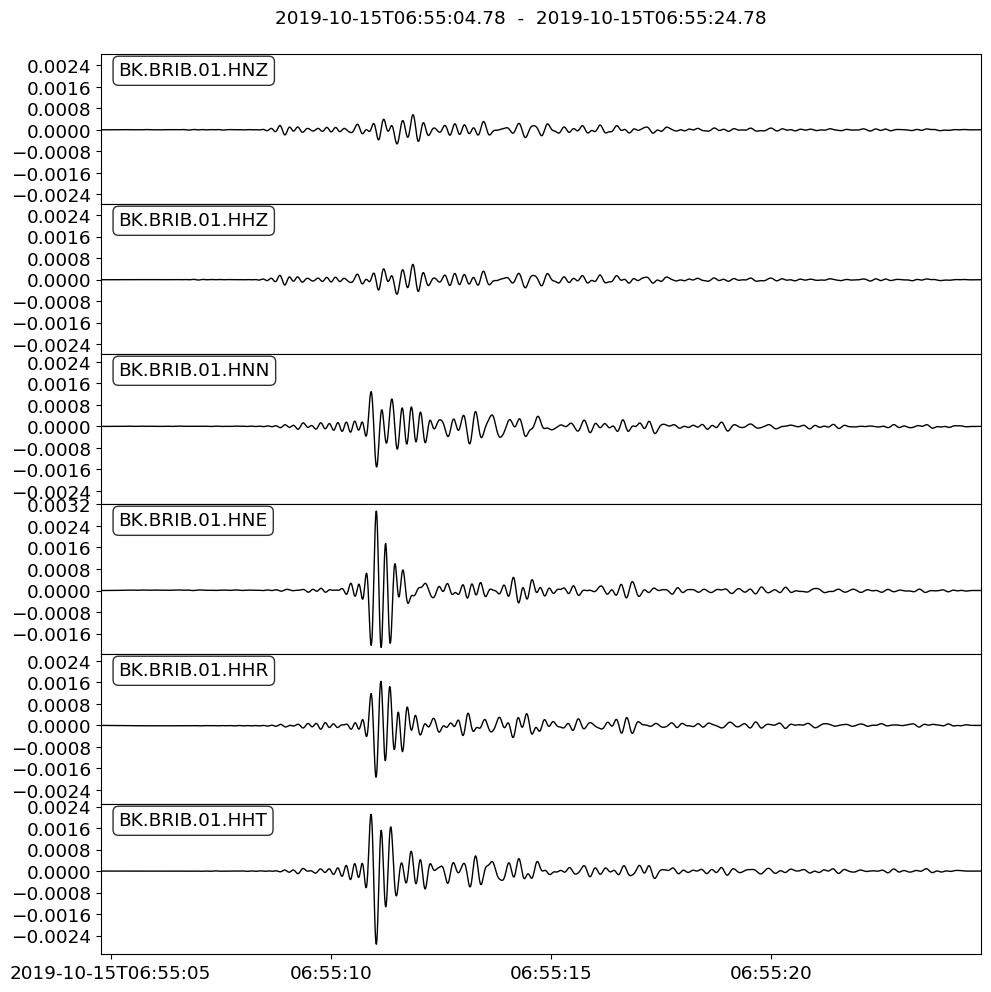

In [35]:
tw_start = origin_time + Pwave_arrival + tw_pre_tw
tw_end = tw_start + tw_trim

#print("# st_start = ",tw_start)
#print("# st_end = ",tw_end)
st_all.trim(tw_start, tw_end)  

st_all.detrend() # remove linear trend
st_all.detrend("demean") # demean
st_all.taper(0.05)

_plot = st_all.plot(size=(1000,1000))

## Normalizing seismic data by total energy

In [36]:
# this works because only one R or T. 
st2r = st_all.select(network=net2, station=sta2, location=loc2, component="R")
st2t = st_all.select(network=net2, station=sta2, location=loc2, component="T")
#print("# st2r = ",st2r)
#print("# st2t = ",st2t)

st2r_total_power_sqrt  = total_power_sqrt(st2r)
st2t_total_power_sqrt  = total_power_sqrt(st2t)
st2_total_power_sqrt = np.sqrt(np.power(st2r_total_power_sqrt, 2) + np.power(st2t_total_power_sqrt, 2))

#print("# st2r_total_power_sqrt  = ",st2r_total_power_sqrt ," st2t_total_power_sqrt  = ",st2t_total_power_sqrt )
#print("# st2_total_power_sqrt  = ",st2_total_power_sqrt)

st2r_norm =  st_normalize(st2r.copy(), st2_total_power_sqrt )
st2t_norm =  st_normalize(st2t.copy(), st2_total_power_sqrt )

# this works because only one N or E. 
st1n = st_all.select(network=net1, station=sta1, location=loc1, component="N")
st1e = st_all.select(network=net1, station=sta1, location=loc1, component="E")

#print("# st1n = ", st1n)
#print("# st1e = ", st1e)

st1n_total_power_sqrt  = total_power_sqrt(st1n)
st1e_total_power_sqrt  = total_power_sqrt(st1e)
st1_total_power_sqrt = np.sqrt(np.power(st1n_total_power_sqrt, 2) + np.power(st1e_total_power_sqrt, 2))

#print("# st1n_total_power_sqrt  = ",st1n_total_power_sqrt ," st1e_total_power_sqrt  = ",st1e_total_power_sqrt )
#print("# st1_total_power_sqrt  = ",st1_total_power_sqrt)

st1n_norm =  st_normalize(st1n.copy(), st2_total_power_sqrt )
st1e_norm =  st_normalize(st1e.copy(), st2_total_power_sqrt )


## Estimating sensor orientation

In [37]:
st1ne_norm = st1n_norm.copy() + st1e_norm.copy()

idaz = 1

#ang_scale = 4 # -> daz = 1.0/4.0 -> 0.25 degrees 
#ang_scale = 5 # -> daz = 1.0/5.0 -> 0.20 degrees 

ang_scale = 1 
az_min = 0
az_max = 361 # to 0 and 360 are the same results


az_max_scaled = az_max * ang_scale


st1n_az = []
coh_median = []

cc_spearmanr = []
cc_pearsonr = []

resi_energy = []

for az_scaled in range(az_min, az_max_scaled, idaz):

    #print("# st1n_az = ",st1n_az)
    #print("# az_scaled = ", az_scaled)
    az = az_scaled / ang_scale
    #print("# az = ", az)
    #break
    azIn = baz1[2]-az
    #print("# azIn = ",azIn)

    if azIn >= 360:
        azIn = azIn - 360
    
    if azIn <= 0:
        azIn = azIn + 360
        
    #print("# azIn = ",azIn)

    st1rt_norm = st1ne_norm.copy().rotate(method='NE->RT',back_azimuth=(azIn))


    st1r_norm = st1rt_norm.select(network=net1, station=sta1, location=loc1, component="R")
    st1t_norm = st1rt_norm.select(network=net1, station=sta1, location=loc1, component="T")

    resiE_r=norm(st1r_norm[0].data - st2r_norm[0].data, 2)
    resiE_t=norm(st1r_norm[0].data - st2r_norm[0].data, 2)
    resiE_total = resiE_r + resiE_t
    #print("# resiE_r = ", resiE_r, "resiE_t = ", resiE_t)
    #print("# resiE_total = ",resiE_total)
    resi_energy.append(resiE_total)
    
    
    # spearmanr cross-correlation
    cc_r_spearmanr, p_r_spearmanr = spearmanr(st1r_norm[0].data, st2r_norm[0].data)
    #print("# cc_spearmanr_r = ", cc_r_spearmanr)
    cc_t_spearmanr, p_t_spearmanr = spearmanr(st1t_norm[0].data, st2t_norm[0].data)
    #print("# cc_spearmanr_t = ", cc_t_spearmanr)
    cc_ave_spearmanr = (cc_r_spearmanr + cc_t_spearmanr ) * 0.5
    cc_spearmanr.append(cc_ave_spearmanr) 

    # pearsonr cross-correlation
    #correlation, pvalue = pearsonr(x,y)
    cc_r_pearsonr, p_r_pearsonr = pearsonr(st1r_norm[0].data, st2r_norm[0].data)
    #print("# cc_spearmanr_r = ", cc_r_spearmanr)
    cc_t_pearsonr, p_t_pearsonr = pearsonr(st1t_norm[0].data, st2t_norm[0].data)
    #print("# cc_spearmanr_t = ", cc_t_spearmanr)
    cc_ave_pearsonr = (cc_r_pearsonr + cc_t_pearsonr ) * 0.5
    cc_pearsonr.append(cc_ave_pearsonr) 

    
    st1n_az.append(az)

    #break

    #print("# st1n_az = ",st1n_az, " coh_med = ",coh_med)
    #print("# az = ",az, " coh_med = ",coh_med, " resiE_total = ", resiE_total)


In [38]:
best_az_resi_energy = st1n_az[np.argmin(resi_energy)]
print("# best_az_resi_energy = ", best_az_resi_energy)
resi_energy_min = resi_energy[np.argmin(resi_energy)]
print("# resi_energy_min = ", resi_energy_min)

cc_spearmanr_max = cc_spearmanr[np.argmax(cc_spearmanr)]
#print("# cc_spearmanr_max = ", cc_spearmanr_max)
best_az_cc_spearmanr = st1n_az[np.argmax(cc_spearmanr)]
#print("# best_az_cc_spearmanr = ", best_az_cc_spearmanr)

cc_pearsonr_max = cc_pearsonr[np.argmax(cc_pearsonr)]
print("# cc_pearsonr_max = ", cc_pearsonr_max)
best_az_cc_pearsonr = st1n_az[np.argmax(cc_pearsonr)]
#print("# best_az_cc_pearsonr = ", best_az_cc_pearsonr)



# best_az_resi_energy =  15.0
# resi_energy_min =  0.11055243691042956
# cc_pearsonr_max =  0.996460983934


## Error analysis for sensor orientation

In [39]:
resi_energy_norm = np.array(resi_energy)/resi_energy_min 

conf_level = 95 
num_para = 2 # fixed. We have two parameters, dt and az

# 2*Tw*fh
# use %d to get integer. Ideally DegOfFreedom would be integer
#set DegOfFreedom = `echo $et_timet9CUTIn $st_timet9CUTIn $fhSACIn | awk '{val=2.0*($1-$2)*$3; printf("%d\n",val);}' `

deg_freedom = int(2.0 * tw_trim * fh)
#print("# deg_freedom = ",deg_freedom)

max_emin = cal_max_emin (conf_level, num_para, deg_freedom)
#print("# max_emin = ", max_emin)

index_select = np.where(  (resi_energy_norm <= max_emin ) )
#print("# index_select = ", index_select)

min_az_resi_energy = st1n_az[index_select[0][0]]
max_az_resi_energy = st1n_az[index_select[0][-1]]

#print("# best_az_resi_energy = ", best_az_resi_energy)
#print("# min_az_resi_energy = ", min_az_resi_energy)
#print("# max_az_refi_energy = ", max_az_resi_energy)


## Rotating target seismic data into ZRT coordinate

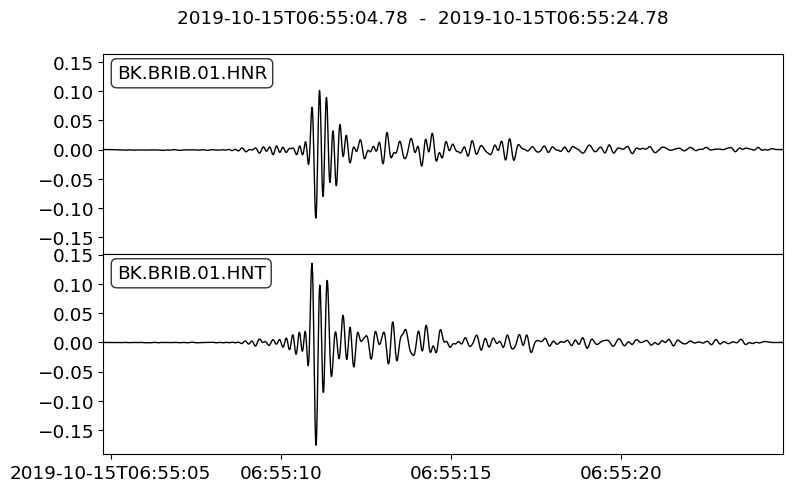

In [40]:

azIn = baz1[2]-best_az_resi_energy 
    #print("# azIn = ",azIn)

if azIn >= 360:
    azIn = azIn - 360
    
if azIn <= 0:
    azIn = azIn + 360
        
#st1rt_norm_best_cc = st1ne_norm.copy().rotate(method='NE->RT',back_azimuth=(baz1[2]-best_az_resi_energy ))
st1rt_norm_best_cc = st1ne_norm.copy().rotate(method='NE->RT',back_azimuth=(azIn ))

st1r_norm_best_cc = st1rt_norm_best_cc .select(network=net1, station=sta1, location=loc1, component="R")
st1t_norm_best_cc = st1rt_norm_best_cc .select(network=net1, station=sta1, location=loc1, component="T")


_plot = st1rt_norm_best_cc.plot()

## Plotting rotated data, and residual energy & cross-correlation value as a function of sensor azimuth

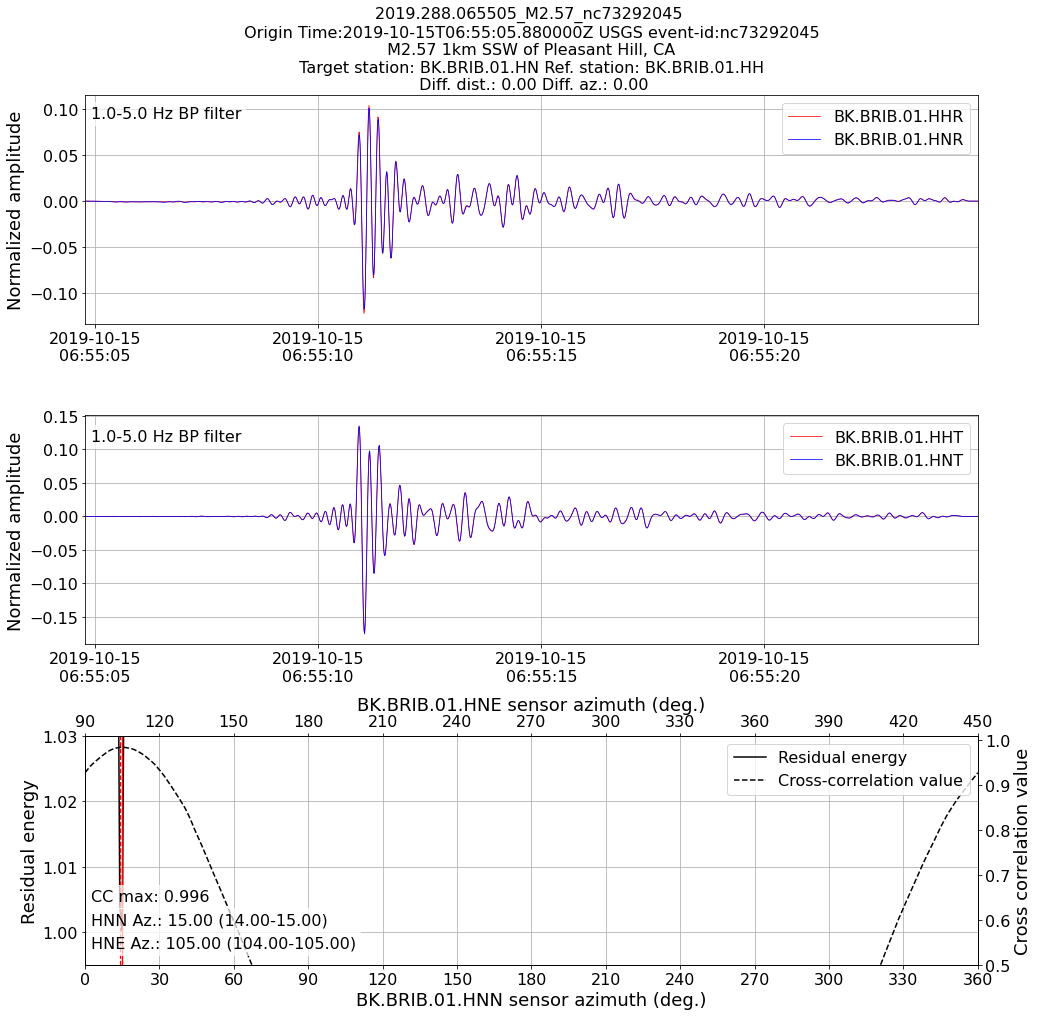

In [41]:

    
target_seedid=st1n_norm[0].stats.network+"."+st1n_norm[0].stats.station+"."+st1n_norm[0].stats.location+"."+st1n_norm[0].stats.channel[:-1]
ref_seedid=st2r_norm[0].stats.network+"."+st2r_norm[0].stats.station+"."+st2r_norm[0].stats.location+"."+st2r_norm[0].stats.channel[:-1]

#plot_xc.BRIB.73292045.BRIB_ref.pdf
plot_fi = plot_dir+"/plot_xc_"+target_seedid+"_ref"+ref_seedid+"_"+event_para+".pdf"

gs = gridspec.GridSpec(3,1)
#gs = gridspec.GridSpec(6,2)

#fig = plt.figure()
fig = plt.figure(figsize=(16, 16))

t=fig.text(0.13, 0.86, str(fl)+"-"+str(fh)+" Hz BP filter")
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

t=fig.text(0.13, 0.58, str(fl)+"-"+str(fh)+" Hz BP filter")
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#ph_l1_out = "{:.3f}".format(ph_l1)

#t=fig.text(0.13, 0.18, "CC max: "+str("{:.3f}".format(cc_spearmanr_max)))
t=fig.text(0.13, 0.18, "CC max: "+str("{:.3f}".format(cc_pearsonr_max)))

t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

target_com1 = st1n_norm[0].stats.channel
best_az1_out = "{:.2f}".format(best_az_resi_energy)
best_az1_min = "{:.2f}".format(min_az_resi_energy)
best_az1_max = "{:.2f}".format(max_az_resi_energy)

target_com2 = st1e_norm[0].stats.channel

best_az2_out = "{:.2f}".format(best_az_resi_energy+90.0)
best_az2_min = "{:.2f}".format(min_az_resi_energy+90.0)
best_az2_max = "{:.2f}".format(max_az_resi_energy+90.0)


#t=fig.text(0.13, 0.16, target_com1+" Az.: "+str("{:.2f}".format(best_az_cc_spearmanr) ))
t=fig.text(0.13, 0.16, target_com1+" Az.: "+best_az1_out+" ("+best_az1_min+"-"+best_az1_max+")" )
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#t=fig.text(0.13, 0.14, target_com2+" Az.: "+str(fl))
#t=fig.text(0.13, 0.14, target_com2+" Az.: "+str("{:.2f}".format(best_az_resi_energy+90.0) ))
t=fig.text(0.13, 0.14, target_com2+" Az.: "+best_az2_out+" ("+best_az2_min+"-"+best_az2_max+")" )

t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(gs[0, 0])

sncl1 = get_seedid(st2r_norm[0])
sncl2 = get_seedid(st1r_norm_best_cc[0])
    
plt.plot_date(st2r_norm[0].times("matplotlib"), st2r_norm[0].data*1, fmt='-', label=sncl1, color="red",  linewidth=0.75, linestyle='solid')
plt.plot_date(st1r_norm_best_cc[0].times("matplotlib"), st1r_norm_best_cc[0].data*1, fmt='-', label=sncl2, color="blue", linewidth=0.75, linestyle='solid')

#myFmt = mdates.DateFormatter("%D/%H:%M") 
myFmt = mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S") 
plt.gca().xaxis.set_major_formatter(myFmt) 


plt.xlim(st2r_norm[0].times("matplotlib")[0], st2r_norm[0].times("matplotlib")[-1])
#plt.ylim(wf_amp_min2 , wf_amp_max2 )
plt.grid()

diff_eq_baz_out = "{:.2f}".format(diff_eq_baz)
diff_eq_dist_out = "{:.2f}".format(diff_eq_dist)

plt.title(event_para+" \n Origin Time:"+str(origin_time)+" USGS event-id:"+evid+" \n M"+str(evmag)+" "+event_region+" \n Target station: "+target_seedid+" Ref. station: "+ref_seedid+" \n Diff. dist.: "+diff_eq_dist_out+" Diff. az.: "+diff_eq_baz_out)

plt.ylabel("Normalized amplitude")
#plt.xlabel("Time")
plt.legend(loc = "upper right")

##
plt.subplot(gs[1, 0])
    

sncl1 = get_seedid(st2t_norm[0])
sncl2 = get_seedid(st1t_norm_best_cc[0])
    
plt.plot_date(st2t_norm[0].times("matplotlib"), st2t_norm[0].data*1, fmt='-', label=sncl1, color="red",  linewidth=0.75, linestyle='solid')
plt.plot_date(st1t_norm_best_cc[0].times("matplotlib"), st1t_norm_best_cc[0].data*1, fmt='-', label=sncl2, color="blue", linewidth=0.75, linestyle='solid')

#myFmt = mdates.DateFormatter("%D/%H:%M") 
myFmt = mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S") 
plt.gca().xaxis.set_major_formatter(myFmt) 


plt.xlim(st2t_norm[0].times("matplotlib")[0], st2t_norm[0].times("matplotlib")[-1])
#plt.ylim(wf_amp_min2 , wf_amp_max2 )
plt.grid()

        

plt.ylabel("Normalized amplitude")
#plt.xlabel("Time")
plt.legend(loc = "upper right")

ax1 = plt.subplot(gs[2, 0])

resi_min = 0.995
resi_max = 1.030

sncl1 = get_seedid(st1n_norm[0])

#ax1.plot(st1n_az, resi_energy/np.amin(resi_energy),  color='black',linestyle="solid",linewidth = 1.5, label="Residual energy")
ax1.plot(st1n_az, resi_energy_norm,  color='black',linestyle="solid",linewidth = 1.5, label="Residual energy")
ax1.plot([best_az_resi_energy, best_az_resi_energy], [resi_min, resi_max], color="red", linewidth=1.25, linestyle="solid")

ax1.plot([min_az_resi_energy, min_az_resi_energy], [resi_min, resi_max], color="red", linewidth=1.25, linestyle="dashed")
ax1.plot([max_az_resi_energy, max_az_resi_energy], [resi_min, resi_max], color="red", linewidth=1.25, linestyle="dashed")


ax1.set_ylabel("Residual energy")
ax1.set_ylim([resi_min, resi_max])


ax1.set_xlabel(sncl1+" sensor azimuth (deg.)")

plt.xlim(0, 360)
plt.xticks(np.arange(0, 360 + 1, 30) )

plt.grid()
#plt.legend()  


ax2 = ax1.twinx()
#ax3 = ax1.twinxy()
ax3 = ax1.twinx().twiny()
#ax3 = ax2.twiny()

#ax2.plot(st1n_az, cc_spearmanr, color="black", marker='o', markersize=3, markerfacecolor='w', markeredgewidth=0.5, markeredgecolor="black")
ax2.plot(st1n_az, cc_spearmanr, color='black',linestyle="dashed",linewidth = 1.5, label="Cross correlation")
ax2.set_ylabel("Cross correlation value")
ax2.set_ylim([0.5, 1.01])
#ax2.legend() 




sncl2 = get_seedid(st1e_norm[0])
ax3.yaxis.set_major_locator(mpl.ticker.NullLocator())
ax3.xaxis.set_ticks_position('top')
ax3.set_xlabel(sncl2+" sensor azimuth (deg.)")




plt.xlim(0, 360)
plt.xticks(np.arange(0, 360 + 1, 30),  list(range(90, 451, 30)))


#plt.show()
from matplotlib.lines import Line2D

colors = ['black', 'black']
styles = ['solid', 'dashed']
#lines = [Line2D([0], [0], color=c, linewidth=1, linestyle="solid") for c in colors]
lines = [Line2D([0], [0], color="black", linewidth=1.5, linestyle=s) for s in styles]

labels = ['Residual energy', 'Cross-correlation value' ]
plt.legend(lines, labels)

#plt.savefig("test.pdf") 
plt.savefig(plot_fi) 
